# Preparation
## Downloading necessary packages

In [280]:
using JuDGE, JuMP, GLPK, CSV, DataFrames, Chain, Statistics, Plots, DataFramesMeta

## Reading csv files

In [487]:

data = CSV.read("degree_hours.csv", DataFrame)
periods = unique(data[!,"period"])
paths =   unique(data[!,"ssp"])

states = []

period = periods[1]
ssp = '-'

# Using Chain for more readable pipeline
result = @chain data begin
    filter(:period => ==(period), _)  # filter first period
    groupby([:quantile,:variable])
    combine(:count => mean => :count)
end

push!(states,Dict(
    :period => period,
    :ssp => "-",
    :degree_hours => result
))

for period in periods[2:end]
    for ssp in paths
        # Using Chain for more readable pipeline
        result = @chain data begin
            filter(:period => ==(period), _) 
            filter(:ssp => ==(ssp), _) 
            select(:quantile, :variable, :count)
        end 
        push!(states,Dict(
            :period => period,
            :ssp => ssp,
            :degree_hours => result
        ))
    end
end
println("ok")
println(length(states))


ok
31


In [488]:
using DataFrames

# Create an empty DataFrame with proper column types
df = DataFrame(
    n = Int[], 
    p = Any[],  # Changed from Any[] to String[] since you're only pushing "-"
    depth = Int[],
    degree = Int[] 
)

for (i, state) in enumerate(states)
    if state[:period] == periods[1]
        println("start")
        push!(df, (n=i, p="-", degree=length(paths), depth=0)) 
    else
        depth = findfirst(x -> x == state[:period], periods) - 1  # Using findfirst instead of findall
        period_prev = periods[depth]

        # Fixed the comparison operator (== instead of =) and added proper conditions
        index = findfirst(x -> x[:period] == period_prev && (state[:ssp] == x[:ssp] || depth == 1), states)
        
        if index === nothing
            error("No matching state found for i=$i")
        end
        
        if state[:period] != periods[end]
            push!(df, (n=i, p=index, degree=2, depth=depth))  
        else
            push!(df, (n=i, p=index, degree=1, depth=depth))
        end
    end
end

CSV.write("Climate_tree.csv",df)

start


"Climate_tree.csv"

In [489]:
df1 = states[1][:degree_hours]
res1 = filter(x -> x["variable"] == "CDH", df1)


22×3 DataFrame
 Row │ quantile     variable  count   
     │ Float64      String3   Float64 
─────┼────────────────────────────────
   1 │  0.0         CDH       82292.2
   2 │  3.45866e-5  CDH         164.4
   3 │  0.286584    CDH         310.2
   4 │  0.582147    CDH         302.4
   5 │  0.883386    CDH         305.4
   6 │  1.19264     CDH         293.8
   7 │  1.51649     CDH         291.8
   8 │  1.84905     CDH         280.2
   9 │  2.20259     CDH         283.4
  10 │  2.56796     CDH         285.2
  11 │  2.9608      CDH         295.2
  12 │  3.36797     CDH         276.4
  13 │  3.79625     CDH         283.4
  14 │  4.26107     CDH         273.0
  15 │  4.77203     CDH         270.4
  16 │  5.33524     CDH         266.4
  17 │  5.96098     CDH         252.4
  18 │  6.6732      CDH         246.8
  19 │  7.51457     CDH         243.8
  20 │  8.55979     CDH         218.6
  21 │ 10.1127      CDH         212.6
  22 │ 20.3303      CDH           0.0

In [120]:
mytree, p = tree_from_file("Climate_tree.csv")
JuDGE.print_tree(mytree)

--1
  --2
    --7
      --12
        --17
          --22
            --27
  --3
    --8
      --13
        --18
          --23
            --28
  --4
    --9
      --14
        --19
          --24
            --29
  --5
    --10
      --15
        --20
          --25
            --30
  --6
    --11
      --16
        --21
          --26
            --31


In [490]:
data = Dict( zip( collect(mytree,order=:breadth), states) )

period = Dict( zip(collect(mytree,order=:breadth), [d[:period] for d in states]))
ssp = Dict( zip(collect(mytree,order=:breadth), [d[:ssp] for d in states]))
degree_hour = Dict( zip(collect(mytree,order=:breadth), [d[:degree_hours] for d in states]))


Dict{AbstractTree, DataFrame} with 31 entries:
  Subtree rooted at node 8… => 44×3 DataFrame…
  Subtree rooted at node 1… => 44×3 DataFrame…
  Subtree rooted at node 1… => 44×3 DataFrame…
  Subtree rooted at node 2… => 44×3 DataFrame…
  Leaf node 29              => 44×3 DataFrame…
  Subtree rooted at node 1… => 44×3 DataFrame…
  Subtree rooted at node 3… => 44×3 DataFrame…
  Subtree rooted at node 1… => 44×3 DataFrame…
  Subtree rooted at node 9… => 44×3 DataFrame…
  Leaf node 31              => 44×3 DataFrame…
  Leaf node 27              => 44×3 DataFrame…
  Subtree rooted at node 6… => 44×3 DataFrame…
  Leaf node 28              => 44×3 DataFrame…
  Subtree rooted at node 2… => 44×3 DataFrame…
  Subtree rooted at node 2… => 44×3 DataFrame…
  Subtree rooted at node 5… => 44×3 DataFrame…
  Subtree rooted at node 1… => 44×3 DataFrame…
  Subtree rooted at node 1… => 44×3 DataFrame…
  Leaf node 30              => 44×3 DataFrame…
  Subtree rooted at node 2… => 44×3 DataFrame…
  Subtree roo

In [491]:
JuDGE.print_tree(mytree,ssp)
JuDGE.print_tree(mytree,period)

--1 (-)
  --2 (ssp119)
    --7 (ssp119)
      --12 (ssp119)
        --17 (ssp119)
          --22 (ssp119)
            --27 (ssp119)
  --3 (ssp126)
    --8 (ssp126)
      --13 (ssp126)
        --18 (ssp126)
          --23 (ssp126)
            --28 (ssp126)
  --4 (ssp245)
    --9 (ssp245)
      --14 (ssp245)
        --19 (ssp245)
          --24 (ssp245)
            --29 (ssp245)
  --5 (ssp370)
    --10 (ssp370)
      --15 (ssp370)
        --20 (ssp370)
          --25 (ssp370)
            --30 (ssp370)
  --6 (ssp585)
    --11 (ssp585)
      --16 (ssp585)
        --21 (ssp585)
          --26 (ssp585)
            --31 (ssp585)
--1 (2021-2031)
  --2 (2031-2041)
    --7 (2041-2051)
      --12 (2051-2061)
        --17 (2061-2071)
          --22 (2071-2081)
            --27 (2081-2091)
  --3 (2031-2041)
    --8 (2041-2051)
      --13 (2051-2061)
        --18 (2061-2071)
          --23 (2071-2081)
            --28 (2081-2091)
  --4 (2031-2041)
    --9 (2041-2051)
      --14 (2051-2061)
        -

In [600]:
H_assets = [:CHP,:Boiler,:Geothermal, :HP]
C_assets = [:HP]
carbon_tax = Dict(
    :ssp1 => Dict(:min => 100, :max => 200),
    :ssp2 => Dict(:min =>  80, :max => 120),
    :ssp3 => Dict(:min =>  50, :max => 80),
    :ssp5 => Dict(:min =>  10, :max => 50)
)



Dict{Symbol, Dict{Symbol, Int64}} with 4 entries:
  :ssp5 => Dict(:max=>50, :min=>10)
  :ssp1 => Dict(:max=>200, :min=>100)
  :ssp3 => Dict(:max=>80, :min=>50)
  :ssp2 => Dict(:max=>120, :min=>80)

In [635]:
JuDGE_SP_Solver = optimizer_with_attributes(GLPK.Optimizer, "msg_lev" => 0, "mip_gap" => 0.0)
function sub_problems(node)
    sp = Model(JuDGE_SP_Solver)

    CDH = filter(x -> x["variable"] == "CDH", degree_hour[node])
    HDH = filter(x -> x["variable"] == "HDH", degree_hour[node])
    
    nCDH = nrow(CDH)
    nHDH = nrow(HDH)
    @variable(sp, 0 <= H_heat_prod[1:nHDH])
    @variable(sp, 0 <= H_heat_unmet[1:nHDH])
    @variable(sp, 0 <= C_heat_prod[1:nCDH])
    @variable(sp, 0 <= C_heat_unmet[1:nCDH])
    @constraint(sp, MeetingHDemand[h in 1:nHDH], H_heat_prod[h] + H_heat_unmet[h] == HDH[h,"quantile"])
    @constraint(sp, MeetingCDemand[h in 1:nCDH], C_heat_prod[h] + C_heat_unmet[h] == CDH[h,"quantile"])
    
    @expansion(sp, 0 <= invest <= 100, lag = 1, duration = 3)
    @capitalcosts(sp, invest*1)
    
    # @variable(sp, y[1:num_items], Bin)
    
    @constraint(sp, H_max_capa[h in 1:nHDH], C_heat_prod[h] <= sum(invest ))
    
    @objective(sp, Min, sum(H_heat_unmet[h] + C_heat_unmet[h] for h in 1:nCDH))
    
    return sp
end

sub_problems (generic function with 1 method)

In [636]:
JuDGE_MP_Solver = optimizer_with_attributes((method=GLPK.INTERIOR) -> GLPK.Optimizer(),
							"msg_lev" => 0, "mip_gap" => 0.0)
judy = JuDGEModel(mytree, ConditionallyUniformProbabilities, sub_problems, JuDGE_MP_Solver)


1

[ Info: Establishing JuDGE model for tree: Subtree rooted at node 1 containing 31 nodes
[ Info: Building JuMP Model for node 


2712172227381318232849141924295101520253061116212631s...Complete
Complete
Complete


[ Info: Checking sub-problem format...
[ Info: Building master problem...


JuDGE Model with:
  Tree: Subtree rooted at node 1 containing 31 nodes
  Expansion variables: invest 

In [637]:
JuDGE.solve(judy,termination=Termination(rlx_abstol=10^-7),verbose=1)


Relaxed ObjVal  |   Upper Bound   Lower Bound  |  Absolute Diff   Relative Diff  |  Fractional  |      Time     Iter
           Inf  |           Inf          -Inf  |            Inf             NaN  |           0  |     0.009        1
  2.947257e+02  |  2.947257e+02          -Inf  |            Inf             NaN  |           0  |     0.011        2
  2.301496e+02  |  2.301496e+02          -Inf  |            Inf             NaN  |           0  |     0.014        3
  1.504798e+02  |  1.504798e+02          -Inf  |            Inf             NaN  |           0  |     0.015        4
  1.353863e+02  |  1.353863e+02          -Inf  |            Inf             NaN  |           0  |     0.015        5
  1.353863e+02  |  1.353863e+02          -Inf  |            Inf             NaN  |           0  |     0.016        6
  1.353863e+02  |  1.353863e+02          -Inf  |            Inf             NaN  |           0  |     0.016        7
  1.353863e+02  |  1.353863e+02          -Inf  |            Inf

[ Info: Solving JuDGE model for tree: Subtree rooted at node 1 containing 31 nodes


In [638]:
solution = JuDGE.solution_to_dictionary(judy)
node = JuDGE.get_node(mytree,[1,5,1,1,1,1])


Subtree rooted at node 26 containing 2 nodes

22×3 DataFrame
 Row │ Keys   H_heat_unmet  H_heat_prod 
     │ Int64  Float64       Float64     
─────┼──────────────────────────────────
   1 │     1           0.0   0.0
   2 │     2           0.0   2.64486e-5
   3 │     3           0.0   0.621909
   4 │     4           0.0   1.23367
   5 │     5           0.0   1.83515
   6 │     6           0.0   2.43077
   7 │     7           0.0   3.03138
   8 │     8           0.0   3.6348
   9 │     9           0.0   4.23829
  10 │    10           0.0   4.84742
  11 │    11           0.0   5.46485
  12 │    12           0.0   6.09205
  13 │    13           0.0   6.74573
  14 │    14           0.0   7.42416
  15 │    15           0.0   8.12186
  16 │    16           0.0   8.81697
  17 │    17           0.0   9.54146
  18 │    18           0.0  10.3686
  19 │    19           0.0  11.366
  20 │    20           0.0  12.7873
  21 │    21           0.0  14.9491
  22 │    22           0.0  31.8297
22×3 DataFrame
 Row │ Keys   C_heat_unmet  C_heat_prod 

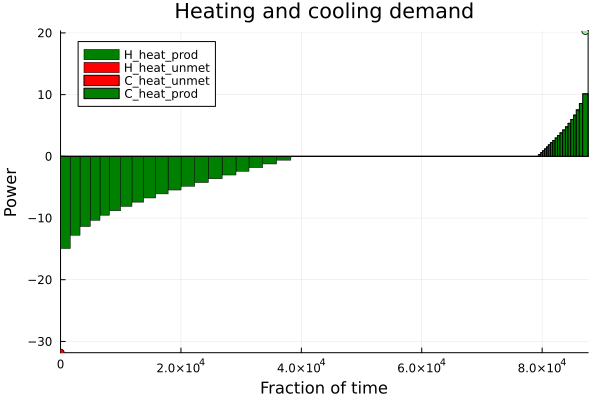

In [639]:
using DataFrames
using Plots

short_sol = solution[node]
HDH = filter(x -> x["variable"] == "HDH", degree_hour[node])
CDH = filter(x -> x["variable"] == "CDH", degree_hour[node])

# Extract keys and sort them
H_keys = sort([parse(Int64, k) for k in keys(short_sol[:H_heat_prod])])

# Prepare data for plotting
H_unmet_values = [short_sol[:H_heat_unmet]["$(key)"] for key in H_keys]
H_prod_values  = [short_sol[:H_heat_prod]["$(key)"] for key in H_keys]
H_hours = Array(HDH[!,"count"])
H_cum_hours = cumsum(H_hours)

# Create DataFrame
df = DataFrame(
    Keys         = H_keys,
    H_heat_unmet = H_unmet_values,
    H_heat_prod  = H_prod_values
)


println(df)
data_matrix = Matrix(df[:, end:-1:2])

# Plotting
groupedbar(
    reverse(cumsum(reverse(H_hours))) .- H_hours/2,          # shifted x-positions
    -data_matrix,
    bar_position = :stack,
    bar_width    = (H_hours),
    label        = ["H_heat_prod" "H_heat_unmet"],
    xlabel       = "Fraction of time",
    ylabel       = "Power",
    title        = "Stacked Bar Plot",
    color       = ["green" "red"],
    xlims        = (0,cum_hours[end]),
    linewidth    = 0.5
)

scatter!(((reverse(cumsum(reverse(H_hours))) .- H_hours/2)[end],-sum(data_matrix[end,:])),markershape=:circle,label="", color = "red")


# Extract keys and sort them
C_keys = sort([parse(Int64, k) for k in keys(short_sol[:C_heat_prod])])

# Prepare data for plotting
C_unmet_values = [short_sol[:C_heat_unmet]["$(key)"] for key in C_keys]
C_prod_values  = [short_sol[:C_heat_prod]["$(key)"] for key in C_keys]
C_hours = Array(CDH[!,"count"])
C_cum_hours = cumsum(C_hours)

# Create DataFrame
df = DataFrame(
    Keys         = C_keys,
    C_heat_unmet = C_unmet_values,
    C_heat_prod  = C_prod_values
)


data_matrix = Matrix(df[:, 2:end])

println(df)
groupedbar!(
    cumsum(C_hours) .- C_hours/2,          # shifted x-positions
    data_matrix,
    bar_position = :stack,
    bar_width    = (C_hours),
    label        = ["C_heat_unmet" "C_heat_prod"],
    xlabel       = "Fraction of time",
    ylabel       = "Power",
    title        = "Heating and cooling demand",
    color       = ["red" "green"],
    xlims        = (0*cum_hours[end],cum_hours[end])
)
scatter!(((cumsum(C_hours) .- C_hours/2)[end-1],sum(data_matrix[end,:])),markershape=:circle,label="", color = "lightgreen")


JuDGE Expansions
Node 1: "invest" 20.330255126953105
Node 12: "invest" 20.330255126953105
Node 13: "invest" 20.330255126953105
Node 14: "invest" 20.330255126953105
Node 15: "invest" 20.330255126953105
Node 16: "invest" 20.330255126953105
Node 1
Node 1,1
Node 1,2
Node 1,3
Node 1,4
Node 1,5
Node 1,1,1
Node 1,2,1
Node 1,3,1
Node 1,4,1
Node 1,5,1
Node 1,1,1,1
Node 1,2,1,1
Node 1,3,1,1
Node 1,4,1,1
Node 1,5,1,1
Node 1,1,1,1,1
Node 1,2,1,1,1
Node 1,3,1,1,1
Node 1,4,1,1,1
Node 1,5,1,1,1
Node 1,1,1,1,1,1
Node 1,2,1,1,1,1
Node 1,3,1,1,1,1
Node 1,4,1,1,1,1
Node 1,5,1,1,1,1
Node 1,1,1,1,1,1,1
Node 1,2,1,1,1,1,1
Node 1,3,1,1,1,1,1
Node 1,4,1,1,1,1,1
Node 1,5,1,1,1,1,1


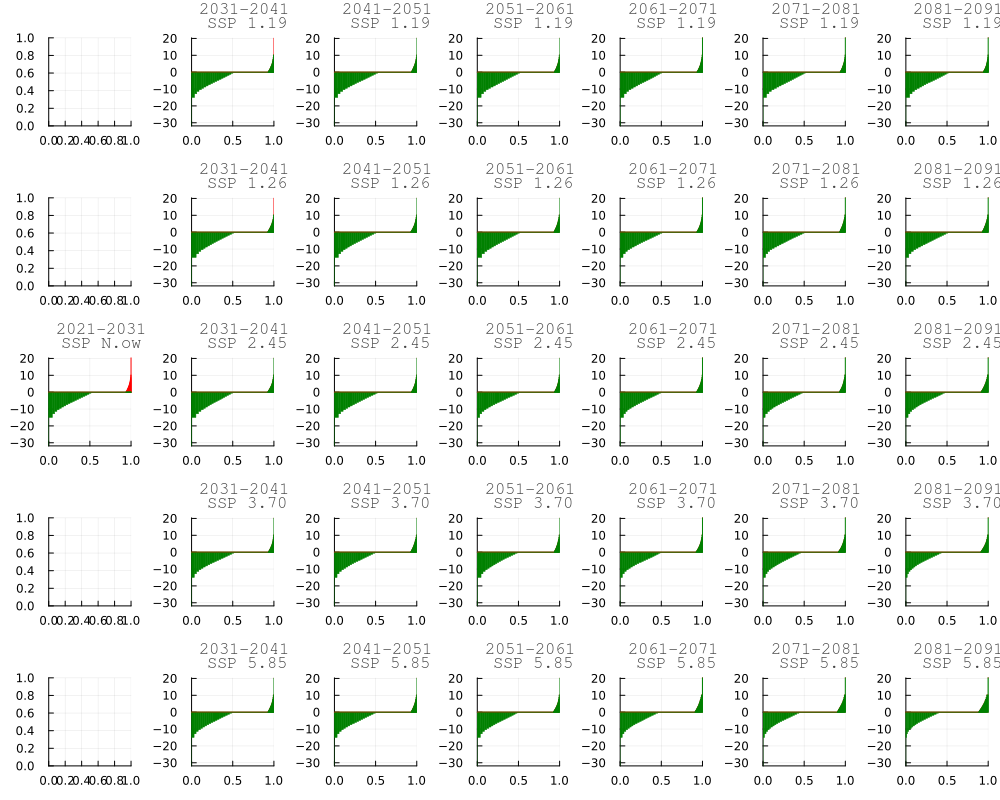

"/home/vub-flow/Documents/Code JuDGE/dummy_results.pdf"

In [641]:
using DataFrames
using Plots

function plot_node_results(judy, mytree)
    # Get solution and node
    solution = JuDGE.solution_to_dictionary(judy)
    
    # Determine layout based on node position
    depth = length(periods)
    if depth == 1  # Root node
        layout = (1, 1)
    else
        n = length(paths)  # Number of branches at first level
        layout = (n, depth)
    end
    
    # Create plot grid
    p = plot(layout=layout, size=(1000, 800), legend=:topright)
    
    # Plot heating and cooling for each subnode
    for (i, pos) in enumerate(get_all_node_positions())
        node = JuDGE.get_node(mytree, pos)
        short_sol = solution[node]

        depth = length(pos)
        # Get subplot position in grid
        if depth == 1
            row = Int(ceil(length(paths)/2))
            col = 1
            path = " Now"
            sp = (row-1)*(layout[2]) + col 
        else
            row = pos[2]
            col = length(pos) 
            sp = (row-1)*(layout[2]) + col 

            path = paths[pos[2]]
        end
        
        # Plot heating
        plot_heating_cooling!(p,sp, solution, pos)
        
        # Add title with node position
        println("Node $(join(pos, ","))")
        title!(p[sp], "$(periods[col])\nSSP $(path[end-2]).$(path[end-1:end])",
                titlefont = font(9,"Arial"))
    end
    
    return p
end

function get_all_node_positions()
    JuDGE.print_expansions(judy)
    res = Vector()
    for period in 1:length(periods)
        for ssp in 1:length(paths)
            
            if period == 1
                node_position = [1]
                push!(res,node_position)
            elseif period == 2
                node_position = [1,ssp]
                push!(res,node_position)
            else
                node_position = vcat([1,ssp],repeat([1], outer = [period - 2]))
                push!(res,node_position)
            end
            if period == 1
                break
            end
        end
    end
    return res
end

function plot_heating_cooling!(p,sp, solution, node_position)
    node = JuDGE.get_node(mytree, node_position)
    short_sol = solution[node]

    heating = true
    cooling = true
    if heating
        # Get degree hour data
        HDH = filter(x -> x["variable"] == "HDH", degree_hour[node])
        # Extract keys and sort them
        H_keys = sort([parse(Int64, k) for k in keys(short_sol[:H_heat_prod])])
        
        # Prepare data for plotting
        H_unmet_values = [short_sol[:H_heat_unmet]["$(key)"] for key in H_keys]
        H_prod_values  = [short_sol[:H_heat_prod]["$(key)"] for key in H_keys]
        H_hours = Array(HDH[!,"count"])
        H_cum_hours = cumsum(H_hours)
        
        # Create DataFrame
        df = DataFrame(
            Keys         = H_keys,
            H_heat_unmet = H_unmet_values,
            H_heat_prod  = H_prod_values
        )
        
        
        data_matrix = Matrix(df[:, end:-1:2])
    
        beg_frac_x = 0.
        end_frac_x = 1.
        incr_frac_x = 0.5
        
        # Plotting
        groupedbar!(
            reverse(cumsum(reverse(H_hours))) .- H_hours/2,          # shifted x-positions
            -data_matrix,
            bar_position = :stack,
            bar_width    = (H_hours),
            label        = ["" ""],
            # xlabel       = "Fraction of time",
            # ylabel       = "Power",
            # title        = "Stacked Bar Plot",
            color       = ["green" "red"],
            linecolor   = ["green" "red"],
            xlims        = (beg_frac_x,end_frac_x).*H_cum_hours[end],
            xticks       = ((beg_frac_x:incr_frac_x:end_frac_x).*H_cum_hours[end], (beg_frac_x:incr_frac_x:end_frac_x)),
            linewidth    = 0.5,
            subplot      = sp
        )
    end

    if cooling
        # Extract keys and sort them
        CDH = filter(x -> x["variable"] == "CDH", degree_hour[node])
        C_keys = sort([parse(Int64, k) for k in keys(short_sol[:C_heat_prod])])
        
        # Prepare data for plotting
        C_unmet_values = [short_sol[:C_heat_unmet]["$(key)"] for key in C_keys]
        C_prod_values  = [short_sol[:C_heat_prod]["$(key)"] for key in C_keys]
        C_hours = Array(CDH[!,"count"])
        C_cum_hours = cumsum(C_hours)
        
        # Create DataFrame
        df = DataFrame(
            Keys         = C_keys,
            C_heat_unmet = C_unmet_values,
            C_heat_prod  = C_prod_values
        )
        
        
        data_matrix = Matrix(df[:, 2:end])
        
        groupedbar!(
            cumsum(C_hours) .- C_hours/2,          # shifted x-positions
            data_matrix,
            bar_position = :stack,
            bar_width    = (C_hours),
            label        = ["" ""],
            # xlabel       = "Fraction of time",
            # ylabel       = "Power",
            # title        = "Heating and cooling demand",
            color       = ["red" "green"],
            linecolor   = ["red" "green"],
            xlims        = (beg_frac_x,end_frac_x).*C_cum_hours[end],
            xticks       = ((beg_frac_x:incr_frac_x:end_frac_x).*C_cum_hours[end], (beg_frac_x:incr_frac_x:end_frac_x)),
            subplot      = sp 
        )
    end
end


p = plot_node_results(judy, mytree)
display(p)
savefig(p, "dummy_results.pdf")

In [436]:
vcat([1,5],repeat([1], outer = [3]))

5-element Vector{Int64}:
 1
 5
 1
 1
 1